# Probability Density Functions

## Probability Density Function
**Probability Density Function (PDF)**: a function that maps a value to its *probability density*.
  * the derivative of a **CDF**

Evaluating a PDF for a *particular value* of *x* is not usually useful. The result is not a probability, but a probability density. Density is `mass per unit of volume`.

##### Examples:  
1. **PDF of an `exponential distribution`**:  
PDF<sub>expo</sub>(*x*) = λe<sup>-λ*x*</sup>

2. **PDF of a `normal distribution`**:  
PDF<sub>normal</sub>(*x*) = (1 / (σ (√2π) ) ) exp [-(1/2) * ( (x-μ) / σ)<sup>2</sup>]

## Probability Density
**Probability Density**: measures *probability per unit of x*
  * you must integrate over *x* to obtain probability mass.
  * a quantity that can be integrated over a *range of values* to yield a probability.
  * Ex: if values are in units of `cm`, then the probability density is in units of `probability per cm`.
  
A probability density value is the *density of distribution* for a given `x` value.


### SciPy Package (scipy.stats.norm.pdf)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

`scipy.stats.norm.pdf(x, loc=0, scale=1)`

The PDF method represents a *normal distribution* and returns the **probability density** of distribution for a given value *x*.

Parameters:
  * **loc**: μ (mu) - mean
  * **scale**: σ (sigma) - standard deviation

### Example: BRFSS - Adult Female Heights

Calculate the density of the distribution for adult female heights at a location *1 standard deviation from the mean*.

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
%matplotlib inline

In [168]:
from brfss import *

risk = ReadBrfss()
female_risk = risk[risk['sex']==2] # filter for female respondents
female_hgt = female_risk['htm3']

female_hgt_mean = np.floor(female_hgt.mean())
female_hgt_std = female_hgt.std()
female_hgt_var = female_hgt.std()**2
print female_hgt_mean, female_hgt_std, female_hgt_var

163.0 7.26915628664 52.8406331196


Adult Female Height Stats:
  * **Mean**: 163 cm
  * **Standard Deviation**: 7.27
  * **Variance**: 52.8

`PDF(mean+std) = 0.333`

The probability density of x, with a value of the mean + 1 standard deviation, is 0.333 (units of probability mass per cm).

In [169]:
# x-values of female height @ 1 std from mean
fhgt_x = female_hgt_mean + female_hgt_std

# Calculate PDF
stats.norm.pdf(fhgt_x, loc=female_hgt_mean, scale=female_hgt_std)

0.033287319047437085

In [170]:
import thinkstats2

mean, var = 163,52.8
std=math.sqrt(var)
pdf = thinkstats2.NormalPdf(mean,std)
pdf.Density(mean+std)

0.033300124989618714

### Plotting

Plotting the PDF portrays the shape of the distribution. This is much more valuable than exploring a the density value for a given value.

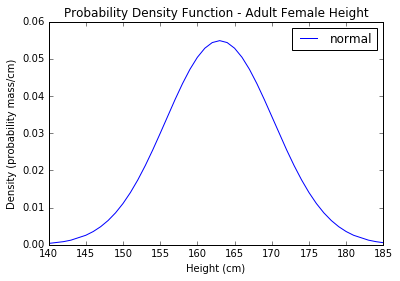

In [171]:
fhgt_pdf = stats.norm.pdf(female_hgt.sort_values(), 
                          loc=female_hgt_mean, 
                          scale=female_hgt_std)

plt.plot(female_hgt.sort_values(), fhgt_pdf, label='normal')
plt.xlim([140,185])
plt.xlabel('Height (cm)')
plt.ylabel('Density (probability mass/cm)')
plt.title('Probability Density Function - Adult Female Height')
plt.legend(loc='upper right')
plt.show()

### PMF
**PMF** can be used as an approximation of the **PDF** distribution.

**PMF** evaluates the probability density at a discrete set of values (as a step function) & approximates the **PDF**. In other words, the PMF of a given value is computed based on the **fraction of the probability density and total probability density**, *as opposed to the frequency and total sample size (`n`)*.

Steps for PMF approximation of PDF:
  1. Generate random sample based on empirical sample's mean (mu) & standard deviation (sigma).
    * Mean & Std gives a representative range of x-values (e.g. height) to model the random sample's distribution.
  2. Compute `PDF(x)` (*probability density*) for each value of the random sample.
  3. Compute `PMF(X)` (*probability* - fraction) for each value, *using the fraction of their probability density*
     * PMF<sub>PDF</sub>(x) = PDF<sub>x</sub> / PDF<sub>total</sub> 

In [172]:
def to_pmf(mu, sigma):
    """Takes the PDF's mean(mu) and standard deviation(sigma) to 
    create a PMF dictionary (probabilities) that approximates the PDF.
    
    """
    # Generate random sample based on mean & std
    low, high = mu-3*sigma, mu+3*sigma
    xs = np.linspace(low, high, 101)
    n = float(sum(xs))
    
    # Compute PDF of random sample - probability density of a given value
    pdf = [stats.norm.pdf(x, loc=mu, scale=sigma) for x in xs]
    pdf_dict = dict(zip(xs,pdf)) # create dict of corresponding xs & PDF value
    
    # Compute PMF - probability of a given value based on probability density (not freq)
    pmf = {} # accumulator
    for val, ds in pdf_dict.items(): # ds = probability density of given value
        pmf[val] = ds / sum(pdf_dict.values()) # fraction of probability density
    return pmf

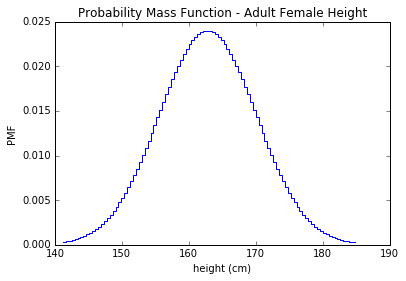

In [173]:
# Find PMF
fhgt_pmf = to_pmf(female_hgt_mean, female_hgt_std)
fhgt_df = pd.DataFrame.from_dict(fhgt_pmf, orient='index')
sort_hgtdf = fhgt_df.sort_index() # sort by height (x-values)

# Plot PMF
fig = plt.figure()
plt.step(sort_hgtdf.index, sort_hgtdf.values)
plt.xlabel('height (cm)')
plt.ylabel('PMF') # Probability Mass Function (probability of a value)
plt.xlim([140,190])
plt.title('Probability Mass Function - Adult Female Height')
plt.show()
plt.close(fig)

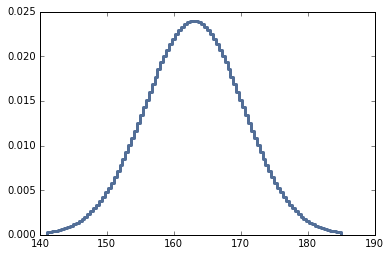

In [174]:
pmf=pdf.MakePmf()
thinkplot.Pmf(pmf)
thinkplot.Show()

## Kernel Density Estimation (KDE)

**Kernel Density Estimation (KDE)** is an algorithm that takes a sample & estimates a **PDF** that fits the data.
  *  estimate the PDF (*probability density*) of a random variable

### Purposes
Estimating a density function with KDE is useful for several purposes:
  1. **Visualization**
     * During the exploration phase off a project, `CDFs` (percentile rank/cumulative probability) are usually the best visualization of a distribution. 
     * After examining a `CDF`, you can decide whether an `estimated PDF` is an appropriate model of distribution.
     * If so, it can be a better option to present the distribution to an audience unfamiliar with `CDFs`.
  2. **Interpolation**
     * An `estimated PDF` is a way to get from a sample to a model of the population.
     * If there's reason to believe that the population distribution is smooth, you can use `KDE` to interpolate the density for values that don't appear in the sample.
  3. **Simulation**
    * Simulations are often based on the distribution of a sample.
    * If the sample size is *small*, it might be appropriate to smooth the sample distribution using `KDE`, which allows the simulation to explore more possible outcomes, *rather than replicating observed data*.


### SciPy Package (scipy.stats.gaussian_kde)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html  
`scipy.stats.gaussian_kde(sample)`

The algorithm applies a filter based on a *Gaussian* distribution to smooth the KDE, providing the estimated PDF.

#### Attributes
  * `.dataset`: dataset with which the gaussian_kde was intialized
  * `.d`: number of dimensions
  * `.n`: number of datapoints
  * `.factor`: bandwidth factor
  * `.covariance` covariance matrix of dataset, scaled by bandwidth factor
  * `.inv_cov`: inverse of covariance  

#### Key Methods
  * `.evaluate(new_sample)`
     1. Create/initialize KDE object - *perform PDF estimation on a sample*
     2. Evaluate new data points (KDE object already initialized)

`Evaluate` method evaluates the estimated PDF on new data points *based on the estimation done on the original sample*.

#### Example: Estimate PDF (compute KDE) based on a Random Sample of Adult Female Heights

1) Generate a random sample from a normal distribution.

`random.gauss(mu, sigma)` generates a random value based on the Gaussian distribution.

In [175]:
sample = [random.gauss(female_hgt_mean, female_hgt_std) for i in range(500)]

In [176]:
# Copy sample for proving function
sample_copy = sample[:]
sample == sample_copy

True

2) Initialize KDE based on the random sample.

In [177]:
sample_kde = stats.gaussian_kde(sample) #estimated PDF

3) Evaluate sample to compute each value's PDFs.

In [178]:
sample.sort()
sample_pdf = sample_kde.evaluate(sample)

In [254]:
def EstimatedPdf(sample):
    """Computes the KDE/estimates PDF of a given sample."""
    kde = stats.gaussian_kde(sample)
    sample.sort()
    est_pdf = kde.evaluate(sample)
    return est_pdf

In [255]:
EstimatedPdf(sample_copy) == sample_pdf

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

**Plot**   
(height vs. estimated PDF (KDE))


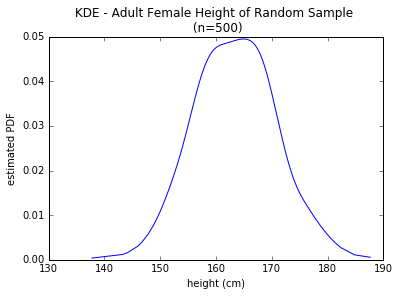

In [256]:
plt.plot(sample, sample_pdf, label='sample KDE')
plt.xlabel('height (cm)')
plt.ylabel('estimated PDF')
plt.title('KDE - Adult Female Height of Random Sample \n (n=500)')

### Plot
Plot the probability density for adult female heights comparing a normal PDF & estimated PDF (KDE). 
  1. a normal PDF that models adult female height in the US.
  2. a kernel density estimate of a sample of 500 random heights.

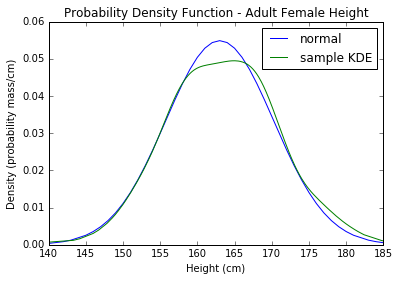

In [257]:
plt.plot(female_hgt.sort_values(), fhgt_pdf, label='normal') # normal PDF
plt.plot(sample, sample_pdf, label='sample KDE') # KDE sample
plt.xlim([140,185])
plt.xlabel('Height (cm)')
plt.ylabel('Density (probability mass/cm)')
plt.title('Probability Density Function - Adult Female Height')
plt.legend(loc='upper right')
plt.show()

The estimate is a good match for the original PDF distribution.

## The Distribution Framework
Can view distributions through **PMFs, CDFs,** & **PDFs**.

#### Probability Mass Function (PMF)
  * PMF represents the **probabilities** for a *discrete* set of values.
  * **PMF** --> **CDF**: *add up* the probability masses to get cumulative probabilities.
  * approximates **PDF**  

#### Cumulative Distribution Function (CDF)
  * CDF represents the **cumulative probabilities** for a set of values.
  * **CDF --> PMF**: compute the *differences* in cumulative probabiltities.

#### Probability Density Function (PDF)
  * A PDF is a derivative of a continuous CDF == a CDF is a integral of a PDF.
  * PDF maps from values to **probability densities**.
  * Integrate to get a probability from probability density.
  * Perform various kinds of *smoothing* to go from a `discrete` to `continuous` distribution.

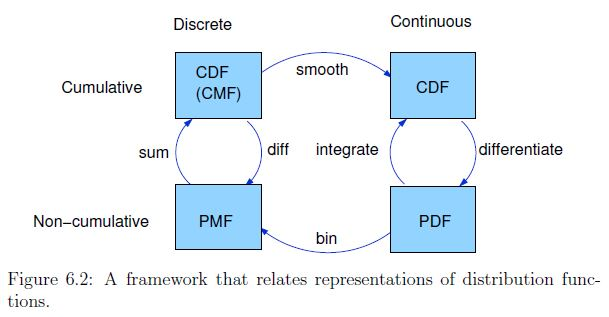

In [2]:
from IPython.display import Image, display
import platform

if platform.system()=='Linux':
    display(Image(filename='/media/cpnguyen/Windows8_OS/Users/Calvin/Desktop/HS 699/code/distribution_framework.JPG'))
if platform.system()=='Windows':
    display(Image(filename='C:\Users\Calvin\Desktop\HS 699\code\distribution_framework.jpg'))

### Smoothing
Smoothing converts *discrete* distribution to one that's *continuous*. 

Options:
1. Assume data came from an `analytic continuous distribution` (e.g. *exponential* or *normal*) and to estimate the parameters of that distribution.
2. **Kernel Density Estimation**

### Discretizing
**Discretize**: to approximate a *continuous* function or distribution with a *discrete* function.
  * the *opposite* of smoothing
  * quantizing

If you evaluate a **PDF** at *discrete* points, you can generate a **PMF** that is an approximation  of the **PDF**. You can get a better approximation using numerical integration.

### Continuous vs. Discrete CDFs
A *discrete* CDF is a "cumulative mass function."

## Distribution Review

#### Histogram
  * each value has a *frequency*
  * frequency should but integers, but can be any numeric type

#### Probability Mass Function (PMF)
  * similar to histograms, but map each value to a *probability*
  * probability should be floating-point numbers
  * PMF is **normalized** if Σ<sub>probabilities></sub> = 1.0

#### Cumulative Distribution Function (CDF)
  * maps each value to *cumulative probabilities*
  * useful to compute `inverse CDF(x)`, which maps from cumulative probabilities to value
  * create CDF from **histogram** by mapping *cumulative probability* to the given value
     * cumulative probability = cumulative frequency /  total frequency
  * compute **PMF** by computing *differences* between consecutive cumulative probabilities

## Moments
Any time you take a sample & reduce it to a *single number*, that number is a **statistic**.
  * **mean**
  * **variance**
  * **standard deviation**
  * **median**
  * **interquartile range**
  
### Raw Moment
**Raw Moment**: a kind of statistic based on  the *sum* of data raised to a power.

When `k=1`, the result is the sample mean (`x̅`). Other raw moments don't mean much by themselves, but are used in some computations.

In [259]:
def RawMoment(sample, k):
    return sum(x**k for x in sample) / len(sample)

In [260]:
RawMoment(sample, 1.0)

163.43497317092135

Calculating the mean the traditional way proves that the mean<sub>sample</sub> == `RawMoment(sample, k=1)`.

In [261]:
raw_mean = float(sum(sample)) / len(sample)
raw_mean

163.43497317092135

### Central Moment
**Central Moment**: a statistic based on *deviation from the mean*, raised to a power.

When `k=2`, the result is the 2nd central moment (which you might recognize as **variance**).
  * The definition of variance gives a hint about why these stats are called moments.

In [262]:
def CentralMoment(sample, k):
    mean = RawMoment(sample, 1)
    return sum((x-mean)**k for x in sample) / len(sample)

In [263]:
CentralMoment(sample,2)

54.043551513941757

Calculating the variance through the Pandas' method proves that `CentralMoment(sample, k=2)` is equivalent to variance<sub>sample</sub>.

In [264]:
pd.Series(sample).var()

54.151855224390509

Important to pay attention to the **units** when reporting moment-based statistics.
#### Example: height in cm
If sample values are in units of cm. 
  * 1st **raw moment**: cm
  * 2nd moment: cm<sup>2</sup>
  * 3rd moment: cm<sup>3</sup>
  
Moments are hard to interpret by themselves. Which is why it's common to report **standard deviation** for the 2nd moment, which is the square root of **variance** (so same unit of 1st moment).

## Skewness

**Skewness**: a property describing the shape of a distribution.
  * a measure of how asymmetric a distribution is  

Types
  * **Unskewed**: distribution is symmetric around its central tendency
  * **Right Skewed**: values extend farther to the right
  * **Left Skewed**: values extend farther to the left

### Skewed vs Bias
Skewness only describes the *shape* of the distribution. It tells nothing about whether the sampling process might have been biased.

### Statistics Quantifying Skewness of Distribution
**Sample Skewness** (*g*<sub>1</sub>): a moment-based statistic intended to quantify the skewness of a distribution.
  * Computing in practice is usually not a good idea. Outliers, if any, have a disproportionate effect.

In [265]:
def StandardizedMoment(sample, k):
    """Normalize the Moment"""
    var = CentralMoment(sample, 2)
    std = math.sqrt(var)
    return CentralMoment(sample, k) / std**k

def Skewness(sample):
    """Computation of g1 (sampled skewness)."""
    return StandardizedMoment(sample, 3) # 3rd standardized moment

*g*<sub>1</sub> is the 3rd **standardized moment**, meaning it has been *normalized* and has no units.

**Standardized Moment**: A *ratio* of moments that has no units.
  * normalized so it has no units
  
**Negative Skewness**: indicates that a distribution skews *left*  
**Positive Skewness**: indiciates that a distribution skews *right*

Magnitude of *g*<sub>1</sub> indicates strength of the skewness. Yet, by itself it's not easy to interpret.

### Drawback of Sample Skewness (*g*<sub>1</sub>) 
Computing **sample skewness** is not practical due to disproportionate effect of outliers. 

### Alternative: Pearson's Median Skewness Coefficient (*g*<sub>p</sub>) 
Equation:
***g*<sub>p</sub> = 3(mean<sub>sample</sub> - median) / standard deviation**

##### An alternative to evaluating the *assymetry of a distribution* is looking at the **relationship between the mean & median**.

  * Extreme values have more effect on the mean than median.
  * A distribution that skews *left* (**mean < median**)
  * A distribution that skews *right* (**mean > median**)

**Pearson's Median Skewness Coefficient**: a measure of skewness based on the difference between the sample mean & median 
  * a statistic intended to quantify the skewness of a distribution based on the median, mean, & standard deivation.
  * statistic is **robust**, meaning it's less vulnerable to the *effect of outliers*.

In [266]:
def EvalCDF(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1
    prob = count / len(sample) # float division
    return prob

def Median(sample):
    cdf = {}
    for x in sample:
        cdf[x] = EvalCDF(sample, x)    
    df = pd.DataFrame(cdf.items(), columns=['value', 'cdf'])    
    index = df[df['cdf'] >=0.50]['cdf'].argmin()
    median = df['value'].loc[index]
    return median

def PearsonMedianSkewness(sample):
    median = Median(sample)
    mean = RawMoment(sample, 1)
    var = CentralMoment(sample, 2)
    std = math.sqrt(var)
    std = pd.Series(sample).std()
    gp = 3 * (mean-median) / std # Pearson Coefficient
    return gp

### Example
#### NSFG - Birthweight

In [267]:
import nsfg

preg = nsfg.ReadFemPreg() # DataFrame
live = preg[preg.outcome==1] # filter for live births
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]
data = live['totalwgt_lb'].dropna()
pdf = EstimatedPdf(data)

C:\Users\Calvin\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


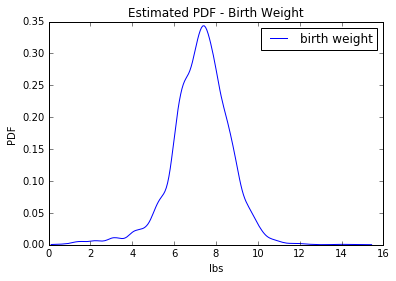

In [268]:
plt.plot(data.sort_values(), pdf, label='birth weight')
plt.xlabel('lbs')
plt.ylabel('PDF')
plt.title('Estimated PDF - Birth Weight')
plt.legend(loc='upper right')
plt.show()

In [269]:
Median(data.values)

7.375

Median is 7.38 lbs.

The Median of a CDF is the value of `CDF(0.50)` (at the 50th percentile).

In [270]:
data.mean()

7.2656284576233681

In [271]:
mean = RawMoment(data.values, 1)
mean

7.2656284576233681

Mean is 7.27 lbs.

**Skewness Coefficient**

In [272]:
Skewness(data.values)

-0.58950626875773648

In [273]:
PearsonMedianSkewness(data.values)

-0.23298739915481315

Sample Skewness (g<sub>1</sub>) is -0.59 and Pearson's Median Skewness (g<sub>p</sub>) is -0.23.

**Interpretation**: The left tail appears longer than the right (**Left Skewed Distribution**).
  * **Mean < Median**, hence consistent with the skew (Mean = 7.27 lbs & Median = 7.38 lbs)
  * Both **skewness coefficients** are negative (sample skewness (*g*<sub>1</sub> = -0.59 & Pearson's median skewness (*g*<sub>p</sub> = - 0.23)
  

#### BRFSS - Adult Weight

In [282]:
brfss = ReadBrfss(nrows=None)
brfss_data = brfss.wtkg2.dropna()

In [297]:
brfss_mean = brfss_data.mean()
brfss_std = brfss_data.std()
brfss_mean, brfss_std

(78.992452996858106, 19.546156913060994)

Generate random sample due to massive dataset of brfss_data based on dataset's mean & standard deviation.

Apply `brfss_xs` (random sample) for such cases and use `brfss_data` (original) for all others where applicable.

In [384]:
brfss_xs = [random.gauss(brfss_mean, brfss_std) for i in range(10000)]
pd.Series(brfss_xs).mean(), pd.Series(brfss_xs).std()

(78.994674060710082, 19.769387272319396)

In [385]:
# brfss_pdf = EstimatedPdf(list(brfss_data))
brfss_pdf = EstimatedPdf(brfss_xs)

brfss_df = pd.concat([pd.Series(brfss_xs), pd.Series(brfss_pdf)], axis=1)
brfss_df.columns=['wgt', 'pdf']
brfss_df.sort_values('wgt')
pass

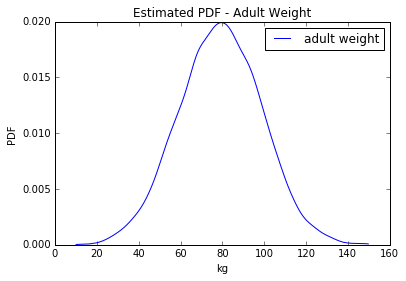

In [386]:
plt.plot(brfss_df.wgt, brfss_df.pdf, label='adult weight')
plt.xlabel('kg')
plt.ylabel('PDF')
plt.title('Estimated PDF - Adult Weight')
plt.legend(loc='upper right')
plt.show()

In [387]:
Median(brfss_xs)

79.091197344231787

Median is 79.0 kg

In [390]:
print pd.Series(brfss_data).mean()
RawMoment(brfss_data, 1)

78.9924529969


78.992452996871975

Mean is 79.0 kg

#### Skewness Coefficient

In [383]:
Skewness(brfss_data)

1.054840012109306

In [389]:
PearsonMedianSkewness(brfss_xs)

-0.014647386212624418

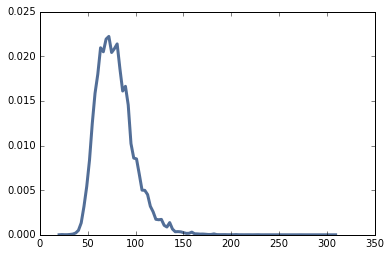

In [391]:
import thinkstats2, thinkplot

brf_pdf = thinkstats2.EstimatedPdf(brfss_data)
thinkplot.Pdf(brf_pdf, label='birth weight')

In [ ]:
print Skewness(brfss_data)

Sample Skewness (g<sub>1</sub>) is +1.1 and Pearson's Median Skewness (g<sub>p</sub>) is +0.26.

**Interpretation**: The right tail appears longer than the left (**Right Skewed Distribution**).
  * **Mean > Median**, hence consistent with the skew (Mean = 79.0 kg & Median = 77.3 kg)
  * Both **skewness coefficients** are positive (sample skewness (*g*<sub>1</sub> = 1.1 & Pearson's median skewness (*g*<sub>p</sub> = 0.26)

The sign of the *skewness coefficient* indicates whether the distribution skews left or right. Other than that, they're hard to interpret.
  * **Sample Skewness** is less robust as it's more susceptible to outliers. As a result it's less reliable when applied to skewed distributions (exactly when it'd be most relevant).
  * **Pearson's Median Skewness** is based on a computed mean & variance. It's also susceptible to outliers, but is somewhat more robust due to the lack of dependence on a third moment.
  